<a href="https://colab.research.google.com/github/bspanswick/STLF/blob/main/LSTM_STLF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

import math 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime 
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt  
import matplotlib.dates as mdates 
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Dropout 
from keras.callbacks import EarlyStopping 
from sklearn.preprocessing import RobustScaler, MinMaxScaler 
import seaborn as sns


In [ ]:
weather = pd.read_csv('/content/drive/MyDrive/AMTLF/weather.csv')
pjm = pd.read_csv('/content/drive/MyDrive/AMTLF/pjm.csv') 

In [ ]:
weather.head()

,DATA_DATE_and_HOUR,TEMPERATURE,WIND_SPEED_MPH,WIND_GUST_MPH,RELATIVE_HUMIDITY,CLOUD_COVER,PRECIPITATION
0,01/Jan/2015 01,17.0,12.0,12.0,49.0,19.0,0.0
1,01/Jan/2015 02,17.0,12.0,12.0,49.0,10.0,0.0
2,01/Jan/2015 03,17.0,14.0,14.0,51.0,0.0,0.0
3,01/Jan/2015 04,16.0,12.0,12.0,54.0,0.0,0.0
4,01/Jan/2015 05,15.0,7.0,7.0,56.0,0.0,0.0


In [ ]:
pjm.head()

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,2017-01-01T20:00:00.000Z,2017-01-01T15:00:00.000Z,RFC,MIDATL,PL,PLCO,4039.059,True
1,2017-01-01T22:00:00.000Z,2017-01-01T17:00:00.000Z,RFC,MIDATL,PL,PLCO,4658.056,True
2,2017-01-02T08:00:00.000Z,2017-01-02T03:00:00.000Z,RFC,MIDATL,PL,PLCO,3854.594,True
3,2017-01-02T11:00:00.000Z,2017-01-02T06:00:00.000Z,RFC,MIDATL,PL,PLCO,4269.468,True
4,2017-01-02T13:00:00.000Z,2017-01-02T08:00:00.000Z,RFC,MIDATL,PL,PLCO,4746.482,True


In [ ]:
#set datetimes and get min/max/mean for days

weather = weather.rename(columns={ weather.columns[0]: "datetime" })
weather.datetime = pd.to_datetime(weather['datetime'])
weather['time'],weather['date']= weather['datetime'].apply(lambda x:x.time()), weather['datetime'].apply(lambda x:x.date())
weather1 = weather.groupby('date').agg({'TEMPERATURE': ['mean', 'min', 'max'],
                                       'RELATIVE_HUMIDITY': ['mean'],
                                       'WIND_GUST_MPH': ['mean'],
                                       'CLOUD_COVER': ['mean'],
                                       'PRECIPITATION': ['mean']})
#convert back to usable dataframe
weather1.columns = ['_'.join(col) for col in weather1.columns]
weather1 = weather1.reset_index()
weather1.date = pd.to_datetime(weather1['date'])

In [ ]:
#get day of week and check for federal holiday

weather1['weekday'] =weather1['date'].dt.dayofweek
weather1['month'] = weather1['date'].dt.month
cal = calendar()
holidays = cal.holidays(start=weather1.date.min(), end=weather1.date.max())
weather1['holiday'] = weather1['date'].isin(holidays).astype(int)

In [ ]:
pjm = pjm.rename(columns={ pjm.columns[1]: "datetime" })
pjm.datetime = pd.to_datetime(pjm['datetime'])
pjm['time'],pjm['date']= pjm['datetime'].apply(lambda x:x.time()), pjm['datetime'].apply(lambda x:x.date())
pjm1 = pjm.groupby('date').agg({'mw': ['max']})
pjm1.columns = ['_'.join(col) for col in pjm1.columns]
pjm1 = pjm1.reset_index()
pjm1.date = pd.to_datetime(pjm1['date'])

In [ ]:
weather1.head()

,date,TEMPERATURE_mean,TEMPERATURE_min,TEMPERATURE_max,RELATIVE_HUMIDITY_mean,WIND_GUST_MPH_mean,CLOUD_COVER_mean,PRECIPITATION_mean,weekday,month,holiday
0,2015-01-01,28.878261,14.0,42.0,54.343478,11.800000,5.686957,0.0000,3,1,1
1,2015-01-02,31.508333,19.0,43.0,61.887500,6.787500,32.333333,0.0000,4,1,0
2,2015-01-03,29.845833,18.0,40.0,80.008333,5.262500,77.025000,47.8500,5,1,0
3,2015-01-04,40.725000,34.0,58.0,78.987500,9.333333,94.629167,30.1125,6,1,0
4,2015-01-05,29.687500,10.0,45.0,56.333333,27.516667,46.662500,0.4125,0,1,0


In [ ]:
#checking some of the data for missing dates, and date ranges

#we have some missing dates from both datasets - I would probably tackle this by imputing values, but for time we'll just leave it out

print(pjm1.date.max())
print(weather1.date.min())
print(pd.date_range(start = weather1.date.min(), end = weather1.date.max() ).difference(weather1.date))
print(pd.date_range(start = weather1.date.min(), end = weather1.date.max() ).difference(pjm1.date))


2019-12-31 00:00:00
2015-01-01 00:00:00
DatetimeIndex([], dtype='datetime64[ns]', freq=None)
DatetimeIndex([], dtype='datetime64[ns]', freq=None)


In [ ]:
df = pd.merge(weather1, pjm1, on='date', how='outer')
df = df.dropna()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [ ]:
df.head()

,TEMPERATURE_mean,TEMPERATURE_min,TEMPERATURE_max,RELATIVE_HUMIDITY_mean,WIND_GUST_MPH_mean,CLOUD_COVER_mean,PRECIPITATION_mean,weekday,month,holiday,mw_max
date,,,,,,,,,,,
2015-01-01,28.878261,14.0,42.0,54.343478,11.800000,5.686957,0.0000,3.0,1.0,1.0,5214.883
2015-01-02,31.508333,19.0,43.0,61.887500,6.787500,32.333333,0.0000,4.0,1.0,0.0,5464.446
2015-01-03,29.845833,18.0,40.0,80.008333,5.262500,77.025000,47.8500,5.0,1.0,0.0,5572.899
2015-01-04,40.725000,34.0,58.0,78.987500,9.333333,94.629167,30.1125,6.0,1.0,0.0,4985.939
2015-01-05,29.687500,10.0,45.0,56.333333,27.516667,46.662500,0.4125,0.0,1.0,0.0,6336.146


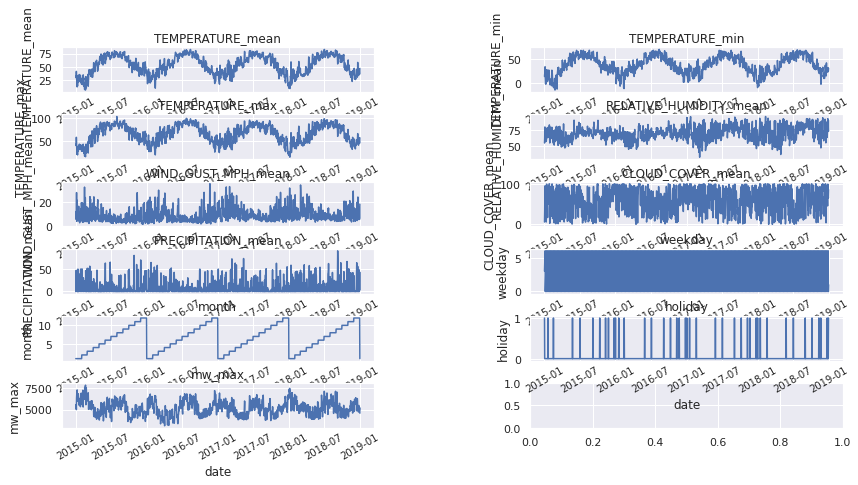

In [ ]:
df_plot = df.copy()

list_length = df_plot.shape[1]
ncols = 2
nrows = int(round(list_length / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(0, list_length):
        ax = plt.subplot(nrows,ncols,i+1)
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.set_title(df_plot.columns[i])
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [ ]:
# Indexing Batches
train_df = df.sort_values(by=['date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# Adding Month and Year in separate columns
# d = pd.to_datetime(train_df.index)
# train_df['Month'] = d.strftime("%m")
# train_df['Year'] = d.strftime("%Y") 

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
train_df.head(5)

,TEMPERATURE_mean,TEMPERATURE_min,TEMPERATURE_max,RELATIVE_HUMIDITY_mean,WIND_GUST_MPH_mean,CLOUD_COVER_mean,PRECIPITATION_mean,weekday,month,holiday,mw_max
0,28.878261,14.0,42.0,54.343478,11.800000,5.686957,0.0000,3.0,1.0,1.0,5214.883
1,31.508333,19.0,43.0,61.887500,6.787500,32.333333,0.0000,4.0,1.0,0.0,5464.446
2,29.845833,18.0,40.0,80.008333,5.262500,77.025000,47.8500,5.0,1.0,0.0,5572.899
3,40.725000,34.0,58.0,78.987500,9.333333,94.629167,30.1125,6.0,1.0,0.0,4985.939
4,29.687500,10.0,45.0,56.333333,27.516667,46.662500,0.4125,0.0,1.0,0.0,6336.146


In [ ]:
# List of considered Features
FEATURES = ['TEMPERATURE_mean', 'TEMPERATURE_min', 'TEMPERATURE_max', 'RELATIVE_HUMIDITY_mean', 'WIND_GUST_MPH_mean'
            , 'CLOUD_COVER_mean', 'PRECIPITATION_mean', 'month', 'weekday', 'holiday', 'mw_max'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['mw_max']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['TEMPERATURE_mean', 'TEMPERATURE_min', 'TEMPERATURE_max', 'RELATIVE_HUMIDITY_mean', 'WIND_GUST_MPH_mean', 'CLOUD_COVER_mean', 'PRECIPITATION_mean', 'month', 'weekday', 'holiday', 'mw_max']


,TEMPERATURE_mean,TEMPERATURE_min,TEMPERATURE_max,RELATIVE_HUMIDITY_mean,WIND_GUST_MPH_mean,CLOUD_COVER_mean,PRECIPITATION_mean,month,weekday,holiday,mw_max,Prediction
1457,45.680556,32.0,57.0,93.208333,8.597222,98.750000,49.041667,12.0,4.0,0.0,5085.966,5085.966
1458,42.537037,29.0,52.0,72.782407,15.175926,71.430556,0.458333,12.0,5.0,0.0,4864.620,4864.620
1459,35.453704,24.0,45.0,73.740741,5.263889,68.263889,1.833333,12.0,6.0,0.0,4948.338,4948.338
1460,35.449074,25.0,46.0,90.828704,6.592593,64.958333,44.000000,12.0,0.0,0.0,5217.259,5217.259
1461,46.388889,31.0,57.0,73.259259,17.958333,85.134259,3.666667,1.0,1.0,1.0,4569.365,4569.365


In [ ]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_mw = pd.DataFrame(data_filtered_ext['mw_max'])
np_mw_scaled = scaler_pred.fit_transform(df_mw)

(1462, 11)


In [ ]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 11

# Prediction Index
index_Close = data.columns.get_loc("mw_max")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(1159, 11, 11) (1159,)
(292, 11, 11) (292,)
0.6460628010816851
0.6460628010816851


In [ ]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

121 11 11


In [ ]:
# Training the model
epochs = 15
batch_size = 7
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/15
166/166 [==============================] - 8s 25ms/step - loss: 0.0213 - val_loss: 0.0170
Epoch 2/15
166/166 [==============================] - 3s 20ms/step - loss: 0.0153 - val_loss: 0.0138
Epoch 3/15
166/166 [==============================] - 3s 21ms/step - loss: 0.0126 - val_loss: 0.0109
Epoch 4/15
166/166 [==============================] - 3s 20ms/step - loss: 0.0104 - val_loss: 0.0099
Epoch 5/15
166/166 [==============================] - 3s 21ms/step - loss: 0.0091 - val_loss: 0.0100
Epoch 6/15
166/166 [==============================] - 3s 21ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 7/15
166/166 [==============================] - 3s 20ms/step - loss: 0.0072 - val_loss: 0.0068
Epoch 8/15
166/166 [==============================] - 3s 20ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 9/15
166/166 [==============================] - 3s 20ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/15
166/166 [==============================] - 3s 20ms/step - loss: 0.0067 - val_lo

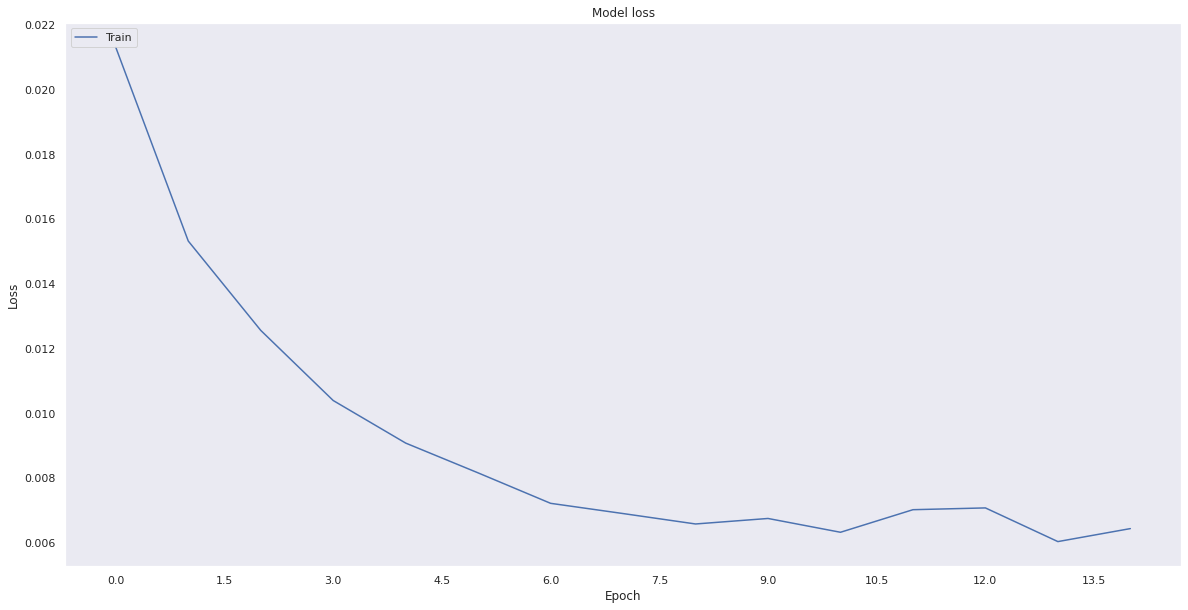

In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()


In [ ]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 316.28
Mean Absolute Percentage Error (MAPE): 6.19 %
Median Absolute Percentage Error (MDAPE): 4.64 %


In [ ]:
y_test_unscaled_df = pd.DataFrame(y_test_unscaled[:,0])
y_y_pred_df = pd.DataFrame(y_pred[:,0])

joinedlist = np.concatenate((y_test_unscaled, y_pred), axis=1)

joinedlist

array([[5588.136     , 5842.40283203],
       [5167.406     , 5705.06738281],
       [4727.129     , 5187.92041016],
       [5542.7       , 5185.98046875],
       [5686.708     , 5327.43945312],
       [5791.296     , 5544.77880859],
       [5595.647     , 5750.75390625],
       [5526.587     , 5773.03808594],
       [4906.72      , 5424.8984375 ],
       [4917.663     , 5047.12255859],
       [5717.83      , 5413.79492188],
       [5573.294     , 5524.51708984],
       [5325.384     , 5430.22802734],
       [4921.831     , 5281.73632812],
       [4388.778     , 4994.85498047],
       [4420.854     , 4534.22216797],
       [4076.96      , 4654.69140625],
       [5104.27      , 4701.06054688],
       [5319.024     , 4992.93017578],
       [5115.679     , 5243.63427734],
       [5541.523     , 5331.81933594],
       [5446.056     , 5658.68017578],
       [4753.021     , 5130.44091797],
       [4851.931     , 4928.17529297],
       [5547.034     , 5366.88720703],
       [5347.981     , 52

In [ ]:
#print(y_pred)

In [ ]:
valid

,TEMPERATURE_mean,Difference,Prediction,TEMPERATURE_min,TEMPERATURE_max,RELATIVE_HUMIDITY_mean,WIND_GUST_MPH_mean,CLOUD_COVER_mean,PRECIPITATION_mean,month,weekday,holiday,mw_max,Date
1170,32.041667,197.709215,5785.845215,19.0,41.0,53.023148,23.810185,54.166667,0.916667,3.0,4.0,0.0,5588.136,2018-03-16
1171,33.921296,234.053961,5401.459961,14.0,50.0,44.037037,13.606481,7.606481,0.000000,3.0,5.0,0.0,5167.406,2018-03-17
1172,35.666667,341.650785,5068.779785,15.0,56.0,44.458333,10.240741,0.027778,0.000000,3.0,6.0,0.0,4727.129,2018-03-18
1173,35.805556,-166.269336,5376.430664,17.0,52.0,45.236111,7.995370,13.009259,0.000000,3.0,0.0,0.0,5542.700,2018-03-19
1174,31.314815,-138.042961,5548.665039,19.0,41.0,46.898148,10.351852,57.300926,14.208333,3.0,1.0,0.0,5686.708,2018-03-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,45.680556,339.054996,5425.020996,32.0,57.0,93.208333,8.597222,98.750000,49.041667,12.0,4.0,0.0,5085.966,2018-12-28
1458,42.537037,-199.732305,4664.887695,29.0,52.0,72.782407,15.175926,71.430556,0.458333,12.0,5.0,0.0,4864.620,2018-12-29
1459,35.453704,-126.494738,4821.843262,24.0,45.0,73.740741,5.263889,68.263889,1.833333,12.0,6.0,0.0,4948.338,2018-12-30
1460,35.449074,101.282992,5318.541992,25.0,46.0,90.828704,6.592593,64.958333,44.000000,12.0,0.0,0.0,5217.259,2018-12-31


NameError: ignored

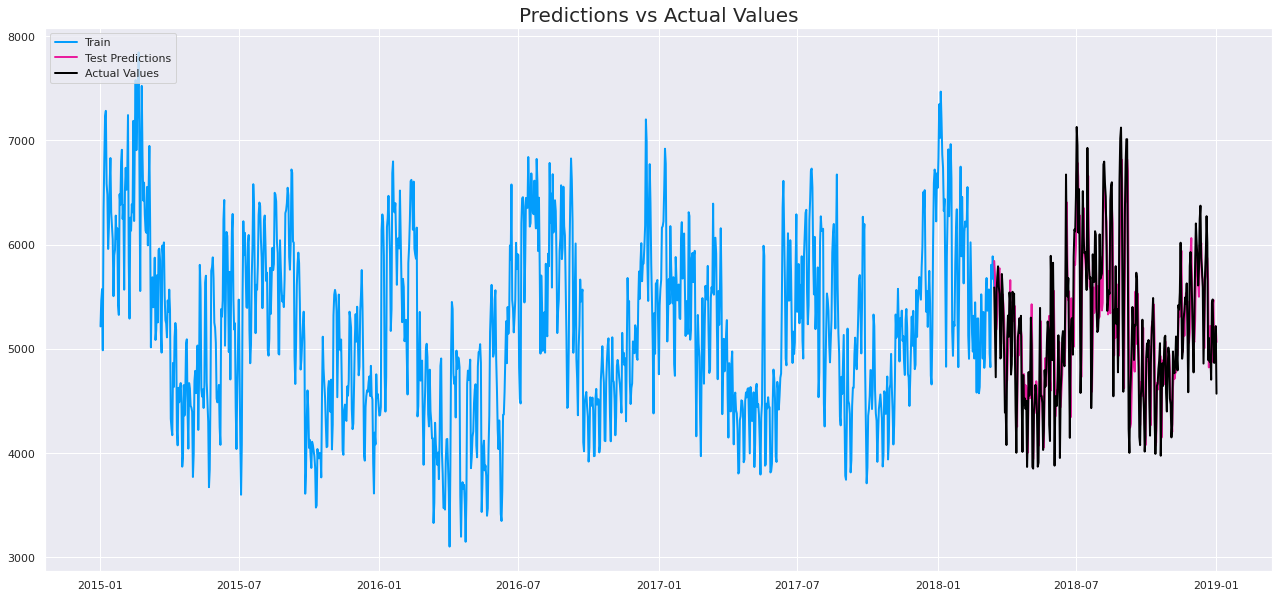

In [ ]:

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = date_index

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["mw_max"], True)

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["mw_max"]]
xv = valid['Date']; yv = valid[["mw_max", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
#plt.ylabel('stockname', fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["mw_max"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

plt.bar(x, y, width=0.8)
plt.grid()
plt.show()